# 1. 芯片初始化操作

In [36]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [37]:
chip=CHIP(PS(host="192.168.1.10", port = 7, delay=0.3, debug=False))
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 59037


In [114]:
# chip.close()

# 2. 读器件

## 2.1 读初始化操作

In [85]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1,tg=5)
chip.set_tia_gain(3)
print(chip.get_setting_info())

## 2.2 读一个器件

In [ ]:
cond,voltage = chip.read_one(row_index=0,col_index=0)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.3 读多行多列

In [ ]:
cond,voltage = chip.read(row_index=[0,1,2,3],col_index=[3,4,6,7],debug=True)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.4 其他读操作

### 2.4.1 自定义读配置

In [ ]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1)
chip.set_tia_gain(3)
print(chip.get_setting_info())

# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([2,4,253,255],row=True,value=None)
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生读脉冲, 并读出tia值
chip.generate_read_pulse()
cond,voltage = chip.get_tia_out([k for k in range(16)])

plot_v_cond(v= voltage,cond= cond)

# 3. 写器件

## 3.1 写初始化

In [ ]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(0.1)
print(chip.get_setting_info())

## 3.2 写一个器件

In [ ]:
chip.write_one(row_index=0,col_index=0,pulse_width=0.1)

## 3.3 其他写操作

### 3.3.1 自定义配置

In [ ]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(0.1)
print(chip.get_setting_info())

# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([2,4,253,255],row=True,value=None)
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生写配置
chip.generate_write_pulse()

# 测试

### 测试新版加速代码

In [159]:
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)                        # 第四步设置, TIA增益

In [160]:
def read2(self,row_index:list,col_index:list,read_voltage:float,tg:float = 5,tia_flag = True, get_tia16 = False):
    """
        读器件, row_index为行索引, col_index为列索引
    """
    assert self.op_mode == "read","未设置为读模式。"

    self.read_voltage = read_voltage
    print(self.get_setting_info())
    # ----------------------------------------------从行还是列去读
    if self.read_from_row:
        # 从行读
        row_bank_ins, col_bank_ins =  PL_ROW_BANK, PL_COL_BANK
        read_ins = PL_READ_ROW_PULSE
    else:
        # 从列读
        row_index, col_index = col_index, row_index
        row_bank_ins, col_bank_ins =  PL_COL_BANK, PL_ROW_BANK
        read_ins = PL_READ_COL_PULSE

    # ----------------------------------------------ins_ram,din_ram,dout_ram的地址
    ins_ram_start = 0
    din_ram_start = 0
    dout_ram_start = 0
    dout_ram_pos = dout_ram_start

    # ----------------------------------------------发送要配置的bank的数据进去
    res_row_bank,res_col_bank,res_col_tia = self.send_din_ram2(row_index,col_index,din_ram_start,tia_flag)

    # ----------------------------------------------准备指令序列
    ins_data = self.get_dac_ins2(v=read_voltage,tg=tg)                                      # 配置电压

    for col in res_col_bank:
        ins_data.append(CMD(PL_CIM_RESET))

        for bank,din_ram_pos in res_row_bank:
            ins_data.append(CMD(row_bank_ins,command_data=CmdData(bank<<8|din_ram_pos)))        # 从din_ram的din_ram_pos位置取数据配置bank

        for bank,din_ram_pos in col:
            ins_data.append(CMD(col_bank_ins,command_data=CmdData(bank<<8|din_ram_pos)))        # 从din_ram的din_ram_pos位置取数据配置bank

        ins_data.append(CMD(read_ins,command_data=CmdData(dout_ram_pos)))                       # 读脉冲, 并将16路TIA的值存在dout_ram的dout_ram_pos位置
        dout_ram_pos = dout_ram_pos + 1

    num = len(ins_data)
    ins_data.insert(0,CMD(PL_DATA_LENGTH,command_data=CmdData(num)))
    ins_data.insert(0,CMD(PL_RAM_ADDR,command_data=CmdData(ins_ram_start)))

    # ----------------------------------------------发送指令序列并执行
    pkts=Packet()
    pkts.append_single(ins_data,mode=4)
    pkts.append_single([CMD(INS_NUM,command_data=CmdData(num))],mode=1)
    pkts.append_single([CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_ins_run))],mode=1)
    self.ps.send_packets(pkts)

    time.sleep(num*0.01)

    vres,cres = self.adc.get_tia_out(num=len(res_col_bank),dout_ram_start=0,read_voltage=read_voltage)
    # vres = [[i for i in range(16)] for j in range(16)]
    # cres = [[i for i in range(16)] for j in range(16)]
    if get_tia16:
        # 直接返回16路TIA的值
        return np.array(vres),np.array(cres)
    else:
        vres_list,cres_list = [0]*len(col_index),[0]*len(col_index)
        # ----------------------------------------------读TIA的值
        for i,v in enumerate(res_col_tia):
            for _,v2 in enumerate(v):
                # v2中数据 (第j[0]列, 第j[4]路TIA)
                vres_list[v2[0]]=vres[i][v2[1]]
                cres_list[v2[0]]=cres[i][v2[1]]

        return np.array(vres_list),np.array(cres_list)

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
[ 0.00251778  0.00167852 -0.00259407  0.0153737  -0.00709555  0.00122074
  0.02273629  0.00755333  0.1320307   0.03437147  0.06984924  0.05504776
  0.07702109  0.06805628  0.03040407  0.01869259]


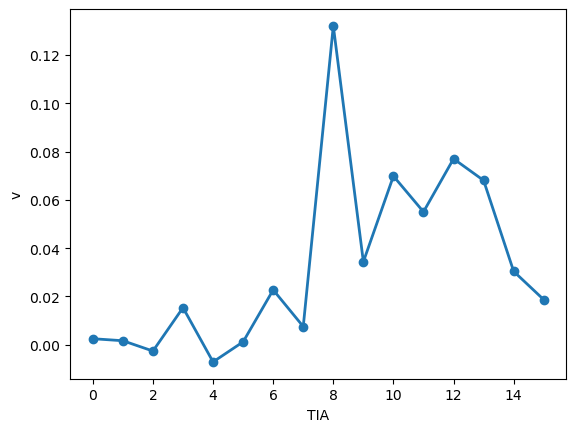

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
[ 0.04100925  0.22099216  0.04428999  0.02300333  0.03448592 -0.00331889
  0.00587481  0.00743889 -0.11833552 -0.03604999 -0.09437849 -0.00747703
 -0.02170629 -0.08461257 -0.00362407 -0.06935331]


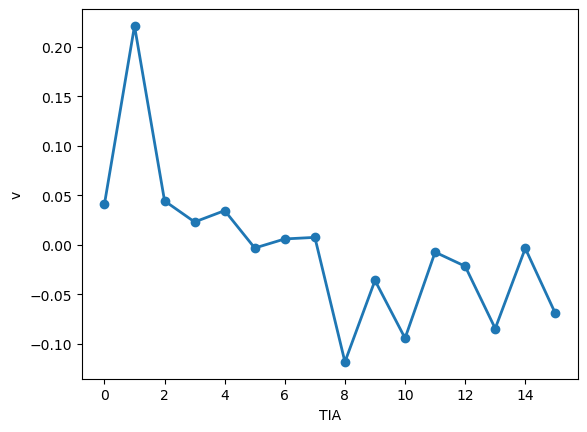

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
[0.00362407 0.00400555 0.04562517 0.03036592 0.04207739 0.00247963
 0.03055666 0.01033815 0.1944792  0.04573962 0.33627583 0.00904111
 0.08426923 0.06412702 0.09979553 0.10292367]


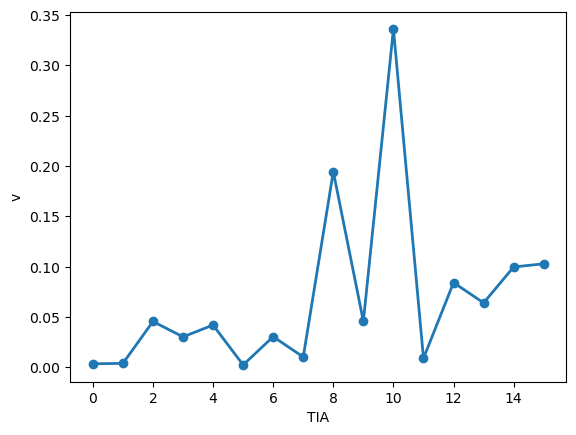

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
[ 5.11185034e-03  4.77233192e-02  1.97378460e-01  1.44657735e-01
 -1.22455519e-02  4.73036897e-03  2.31559191e-02  5.07751701e-02
  8.16370128e-03  9.11740471e-03  9.26999725e-03 -3.08999908e-03
  1.78914762e-02 -6.48518326e-03  1.03381451e-02 -1.14444411e-04]


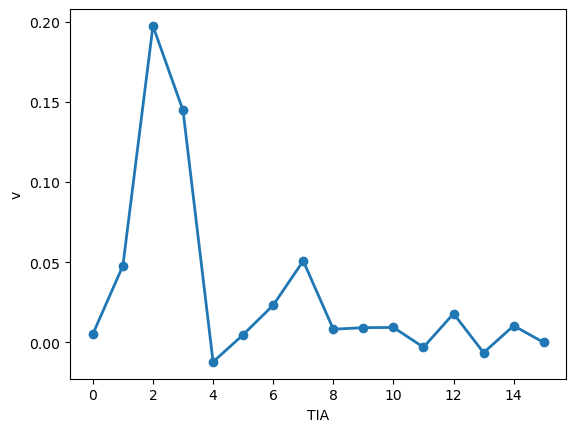

In [162]:
# print("",)
vres,cres = read2(chip,row_index=[0],col_index=[i for i in range(0,64,2)],read_voltage=0.1,tg=5,tia_flag=False,get_tia16=True)
print(vres[0])
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(vres[0], marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

vres,cres = read2(chip,row_index=[0],col_index=[i for i in range(1,65,2)],read_voltage=0.1,tg=5,tia_flag=False,get_tia16=True)
print(vres[0])
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(vres[0], marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

vres,cres = read2(chip,row_index=[0],col_index=[i for i in range(64,128,2)],read_voltage=0.1,tg=5,tia_flag=False,get_tia16=True)
print(vres[0])
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(vres[0], marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

vres,cres = read2(chip,row_index=[0],col_index=[i for i in range(65,129,2)],read_voltage=0.1,tg=5,tia_flag=False,get_tia16=True)
print(vres[0])
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(vres[0], marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

[0.004234443189794611, 0.2052369762260811, 0.1815088351084933, 0.141109958189642, 0.01617481002227851, 0.17635883663441876, -0.008659627063814204, 0.0718710898159734, 0.050431836909085356, 0.003624073000274667, 0.19814142277291175, -0.006485183263649403, 0.03269295327616199, 0.2143543809320353, 0.15812402722251045, 0.024796288949247722]


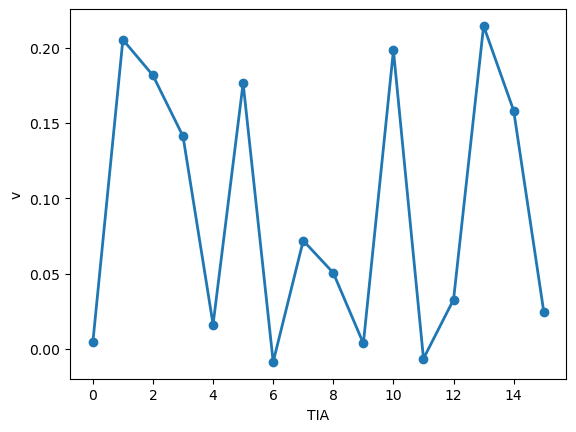

In [115]:
ins_data = [
    CMD(PL_READ_ROW_PULSE,command_data=CmdData(0)),
]
num = len(ins_data)
ins_data.insert(0,CMD(PL_DATA_LENGTH,command_data=CmdData(num)))
ins_data.insert(0,CMD(PL_RAM_ADDR,command_data=CmdData(0)))

pkts=Packet()
pkts.append_single(ins_data,mode=4)
pkts.append_single([CMD(INS_NUM,command_data=CmdData(num))],mode=1)
pkts.append_single([CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_ins_run))],mode=1)
chip.ps.send_packets(pkts)

vres,cres = chip.adc.get_tia_out(num=1,dout_ram_start=0,read_voltage=0.1)

print(vres[0])
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(vres[0], marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

## debug版本读

In [104]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1,tg=5)
chip.set_tia_gain(1)

[ 0.03650777  0.23567919  0.18337809  0.12794885  0.05912961  0.17994476
 -0.01586962  0.08651997 -0.07942442  0.02327036  0.09197516 -0.00309
 -0.11001923  0.18692587  0.04531999  0.07614368]


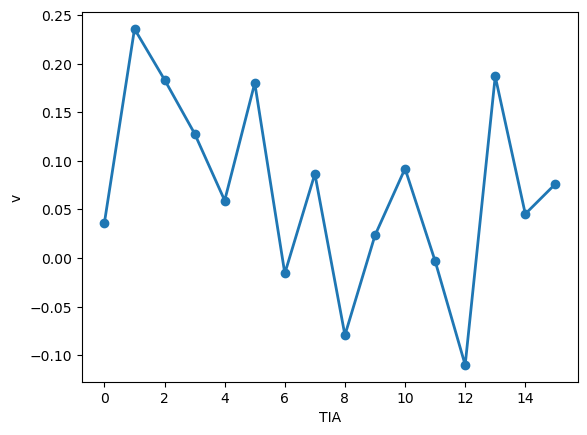

In [45]:
# chip.set_cim_reset()
# chip.generate_read_pulse()

cond1,voltage1 = chip.get_tia_out([k for k in range(16)])
print(voltage1)
cond1,voltage1 = cond1,voltage1
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(voltage1, marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

[ 0.07667776  0.19997253  0.17887661  0.51065096  0.07396924  0.17670217
 -0.01358074  0.06492813  0.31125065  0.27993103  0.4996643   0.23579363
  0.29202399  0.75731681  0.34211249  0.08350627]


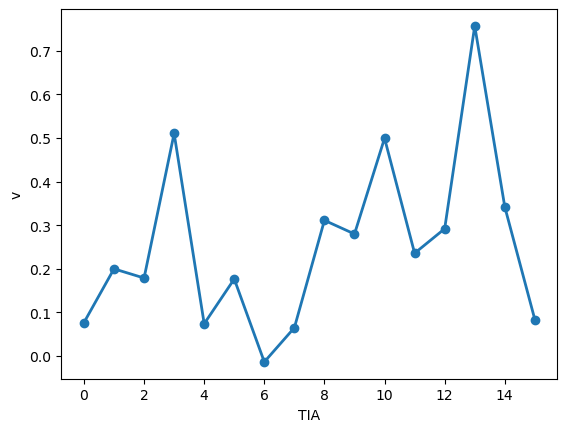

In [105]:


chip.set_cim_reset()
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.generate_read_pulse()

cond1,voltage1 = chip.get_tia_out([k for k in range(16)])
print(voltage1)
cond1,voltage1 = cond1,voltage1
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(voltage1, marker='o', linestyle='-', linewidth=2,label="1")
plt.show()

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
[ 3.62407300e-03  1.67851802e-03  7.62962737e-04  5.07370220e-03
 -8.77407147e-03  6.86666463e-04  2.10577715e-02  9.04110843e-03
  4.23825800e-02  4.18866543e-02  5.25032807e-01  8.01110874e-04
  8.43073824e-03 -2.67036958e-04  3.99792474e-02  3.18155461e-02]


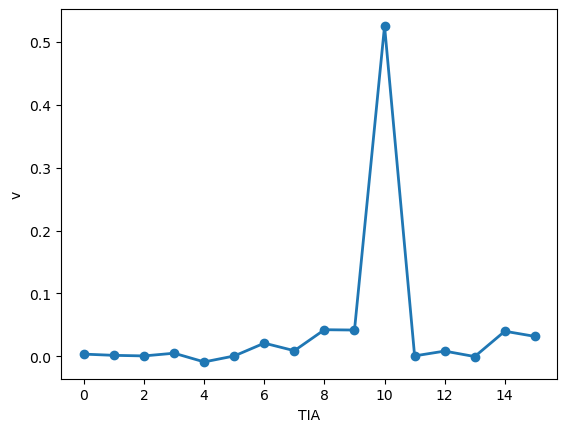

In [ ]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1)
chip.set_tia_gain(3)
print(chip.get_setting_info())

for i in range(256)
    # 先需要reset所有的latch
    chip.set_cim_reset()

    # 配置行bank
    chip.set_latch([0],row=True,value=None)
    chip.set_latch([i],row=False,value=None)

    # 配置列bank
    # chip.set_latch([[2,4,1,3]],row=False,value=None)
    # chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

    # 产生读脉冲, 并读出tia值
    chip.generate_read_pulse()
    cond,voltage = chip.get_tia_out([k for k in range(16)])

    print(voltage)
    plt.figure()
    plt.ylabel("v")
    plt.xlabel("TIA")
    plt.plot(voltage, marker='o', linestyle='-', linewidth=2,label="1")
    plt.show()